In [1]:
import os
import shutil
import traceback
from pathlib import Path

import wandb
import optuna
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, optim
from tqdm import tqdm
from IPython.display import clear_output
from torchaudio.datasets import SPEECHCOMMANDS

In [5]:
DATASET_DIR = Path('data/SpeechCommands')

In [44]:
if not DATASET_DIR.exists():
     SPEECHCOMMANDS('data', download=True)

100%|██████████| 2.26G/2.26G [01:07<00:00, 36.1MB/s]


In [41]:
!rm data/speech_commands_v0.02.tar.gz

In [45]:
for label_dir in Path(DATASET_DIR, 'speech_commands_v0.02').glob('*'):
    if label_dir.is_dir() and label_dir.name not in ['yes', 'no']:
        shutil.rmtree(label_dir)

In [47]:
!sed -i '/no\/\|yes\//!d' data/SpeechCommands/speech_commands_v0.02/testing_list.txt
!sed -i '/no\/\|yes\//!d' data/SpeechCommands/speech_commands_v0.02/validation_list.txt

In [48]:
train_dataset = SPEECHCOMMANDS('data', subset='training')
val_dataset = SPEECHCOMMANDS('data', subset='validation')
test_dataset = SPEECHCOMMANDS('data', subset='testing')

In [50]:
set(map(lambda x: x[1], train_dataset)), set(map(lambda x: x[1], val_dataset)), set(map(lambda x: x[1], test_dataset))

({16000}, {16000}, {16000})

In [54]:
np.unique(list(map(lambda x: x[2], train_dataset)), return_counts=True)

(array(['no', 'yes'], dtype='<U3'), array([3130, 3228]))

In [55]:
np.unique(list(map(lambda x: x[2], val_dataset)), return_counts=True)

(array(['no', 'yes'], dtype='<U3'), array([406, 397]))

In [57]:
np.unique(list(map(lambda x: x[2], test_dataset)), return_counts=True)

(array(['no', 'yes'], dtype='<U3'), array([405, 419]))

In [59]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [112]:
class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.bn1(x))
        x = self.pool1(x)
        x = self.conv2(x)
        x = F.relu(self.bn2(x))
        x = self.pool2(x)
        x = self.conv3(x)
        x = F.relu(self.bn3(x))
        x = self.pool3(x)
        x = self.conv4(x)
        x = F.relu(self.bn4(x))
        x = self.pool4(x)
        x = F.avg_pool1d(x, x.shape[-1])
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        return F.log_softmax(x, dim=2)

In [61]:
from melbanks import LogMelFilterBanks

In [66]:
mel = LogMelFilterBanks()
mel

LogMelFilterBanks()

In [113]:
model = M5(n_input=1, n_output=2)
model.to(device)
print(model)


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


n = count_parameters(model)
print("Number of parameters: %s" % n)

M5(
  (conv1): Conv1d(1, 32, kernel_size=(80,), stride=(16,))
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(32, 64, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=64, out_features=2, bias=True)
)
Number

In [26]:
class ModelTrainerBase:
    def __init__(self, train_loader, test_loader, classes,
                 project_name='itmo-distil',
                 checkpoint_folder='./temp', preview_samples_n=10):
        self.project_name = project_name
        self.checkpoint_folder = checkpoint_folder
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.true_val_labels = np.hstack([x[1].numpy() for x in test_loader])
        self.samples = list(map(lambda img: (img - img.min()) / (img.max() - img.min()),
                                next(iter(test_loader))[0][:10].permute((0, 2, 3, 1)).numpy()))
        self.preview_samples_n = preview_samples_n
        self.best_metric = 0.0
        self.classes = classes
        
    def create_confusion_matrix_plot(self, y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=self.classes, yticklabels=self.classes)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        return plt
    
    def visualize_samples(self, samples, preds, true_labels):
        fig, axes = plt.subplots(1, len(samples), figsize=(15, 8))
        for i, (img, pred, label) in enumerate(zip(samples, preds, true_labels)):
            # img = 
            axes[i].imshow(img)
            axes[i].set_title(f'Pred: {self.classes[pred]}', color='green' if pred == label else 'red')
            axes[i].axis('off')
        plt.tight_layout()
        pred_plot = fig
        return pred_plot


    def validate(self, model, device):
        model.eval()
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.append(preds.cpu().numpy())
        all_preds = np.hstack(all_preds)

        metrics = {
            'val_acc': np.mean(all_preds == self.true_val_labels),
            'val_precision': precision_score(self.true_val_labels, all_preds, average='weighted'),
            'val_recall': recall_score(self.true_val_labels, all_preds, average='weighted')
        }
        metrics['val_f1'] = 2 * metrics['val_precision'] * metrics['val_recall'] \
              / (metrics['val_precision'] + metrics['val_recall'])
        
        # Create and log confusion matrix
        pred_plot = self.visualize_samples(self.samples, all_preds[:self.preview_samples_n], 
                                           self.true_val_labels[:self.preview_samples_n])
        cm_plot = self.create_confusion_matrix_plot(self.true_val_labels, all_preds)
        
        return metrics, cm_plot, pred_plot
        
    def save_model_to_wandb(self, run):
        artifact = wandb.Artifact(
                            name=f"{run.name}-best",
                            type="model",
                            description=f"Best model checkpoint"
                        )
        artifact.add_file(str(self.best_model_path), overwrite=True)
        run.log_artifact(artifact)
        
    def save_model_locally(self, model, optimizer, metrics):
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'metrics': metrics,
        }, self.best_model_path)

        
    def track_progress(self, metrics,  patience, trial, epoch, epochs_without_improvement):
        if metrics['val_f1'] > self.best_metric:
            epochs_without_improvement = 0
            self.best_metric = metrics['val_f1']
            # Save new best model
            self.best_model_path = Path(self.checkpoint_folder) / f'best_model_f1_{metrics["val_f1"]:.4f}.pth'
        else:
            if epochs_without_improvement > patience:
                print('Early stopping')
                raise optuna.TrialPruned()
            epochs_without_improvement += 1
        if trial:
            trial.report(metrics['val_f1'], epoch)
            if trial.should_prune():
                print('[OPTUNA] Run pruned')
                raise optuna.TrialPruned()
        return epochs_without_improvement
    
    def log_metrics(self, run, metrics, cm_plot, epoch, progress_bar, n_epochs):
        run.log({**metrics,"confusion_matrix": wandb.Image(cm_plot) if epoch % 10 == 0 else None})
        progress_bar.set_postfix({
            'train_loss': f"{metrics['train_loss']:.4f}",
            'train_f1': f"{metrics['train_f1']:.4f}",
            'val_f1': f"{metrics['val_f1']:.4f}"
        })
        print(f'Epoch {epoch + 1}/{n_epochs}:')
        print(f'Train - Loss: {metrics["train_loss"]:.4f}, Acc: {metrics["train_acc"]:.4f}, F1: {metrics["train_f1"]:.4f}')
        print(f'Val - Acc: {metrics["val_acc"]:.4f}, F1: {metrics["val_f1"]:.4f}')
        print(f'Best F1: {self.best_metric:.4f}')

    def cleanup(self):
        if os.path.exists(self.checkpoint_folder):
            shutil.rmtree(self.checkpoint_folder)
        os.makedirs(self.checkpoint_folder)



In [ ]:
class ModelTrainer(ModelTrainerBase):
    def train_epoch(self, model, optimizer, loss_fn, device):
        model.train()
        losses = []
        all_preds = []
        all_labels = []
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            losses.append(loss.item())
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        all_preds = np.hstack(all_preds)
        all_labels = np.hstack(all_labels)


        metrics = {
            'train_loss': np.mean(losses),
            'train_acc': np.mean(np.array(all_preds) == np.array(all_labels)),
            'train_precision': precision_score(all_labels, all_preds, average='weighted'),
            'train_recall': recall_score(all_labels, all_preds, average='weighted')
        }
        metrics['train_f1'] = 2 * metrics['train_precision'] * metrics['train_recall'] \
              / (metrics['train_precision'] + metrics['train_recall'])
        
        return model, metrics

    def objective(self, trial, model_class, loss_fn, optim_class, device, n_epochs=100):
        """Optuna objective function for optimizing learning rate"""
        # Define learning rate to optimize
        lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
        
        # Train the model
        self.best_metric = 0
        
        self.train(
            model=model_class(),
            loss_fn=loss_fn,
            optim_class=optim_class,
            optim_args={'lr': lr},
            device=device,
            n_epochs=n_epochs,
            trial=trial
        )

        if self.best_metric > self.best_metric_optuna:
            self.best_model_path_optuna = self.best_model_path
            self.best_metric_optuna = self.best_metric

        
        return self.best_metric  # Return the best validation F1 score

    def optimize_lr(self, model_class, optim_class, loss_fn, n_trials=20, n_epochs=100, 
                   device='cuda' if torch.cuda.is_available() else 'cpu'):
        """Run Optuna optimization for learning rate"""
        self.best_metric_optuna = 0
        study = optuna.create_study(
            direction='maximize',
            study_name='learning_rate_optimization',
            pruner=optuna.pruners.MedianPruner(),
        )
        
        try:
            study.optimize(
                lambda trial: self.objective(
                    trial, 
                    model_class, 
                    loss_fn, 
                    optim_class,
                    device, 
                    n_epochs
                ),
                n_trials=n_trials,
                show_progress_bar=True
            )
            
            # Print optimization results
            artifact = wandb.Artifact(
                name=f"{model_class.__name__}-{optim_class.__name__}{study.best_params['lr']}",
                type="model",
                description=f"OPTUNA Best model checkpoint"
            )
            if self.best_model_path_optuna:
                artifact.add_file(str(self.best_model_path_optuna), overwrite=True)
                wandb.log_artifact(artifact)
            print("\nOptimization Results:")
            print(f"Best learning rate: {study.best_params['lr']}")
            print(f"Best value (F1 score): {study.best_value:.4f}")
            
            # Create and save visualization plots
            try:
                fig1 = optuna.visualization.plot_optimization_history(study)
                fig2 = optuna.visualization.plot_param_importances(study)
                
                # Save plots if wandb is being used
                wandb.log({
                    "optimization_history": fig1,
                    "parameter_importances": fig2
                })
            except (ImportError, Exception) as e:
                print(f"Could not create visualization plots: {str(e)}")
            
            return study.best_params['lr'], study
            
        except Exception as e:
            print(f"Optimization failed: {str(e)}")
            return None, None

    def train(self, model, loss_fn, optim_class, optim_args, 
        device='cuda' if torch.cuda.is_available() else 'cpu', 
        n_epochs=100, patience=10, trial=None, save_model=True):
        run = wandb.init(project=self.project_name, name=f'{model.__class__.__name__}_{optim_class.__name__}lr{np.round(optim_args["lr"], 5)}')
        optimizer = optim_class(model.parameters(), **optim_args)
        model = model.to(device)
        self.best_model_path = None
        progress_bar = tqdm(range(n_epochs), desc='Training', leave=True)
        epochs_without_improvement = 0
        self.cleanup()
        try:
            for epoch in progress_bar:
                # Training phase
                model, train_metrics = self.train_epoch(model, optimizer, loss_fn, device)
                
                # Validation phase
                val_metrics, cm_plot, pred_plot = self.validate(model, device)
                metrics = {**train_metrics, **val_metrics, 'epoch': epoch}
                epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
                if epochs_without_improvement == 0:
                    self.save_model_locally(model, optimizer, metrics)
                self.log_metrics(run, metrics, cm_plot, epoch, progress_bar, n_epochs)
                clear_output(wait=True)
                plt.show()
        except (Exception, KeyboardInterrupt) as e:
            print(traceback.format_exc())
        finally:
            if save_model and self.best_model_path:
                self.save_model_to_wandb(run)
            progress_bar.close()
            wandb.finish()
        return model

In [27]:
trainer = ModelTrainer(train_loader, test_loader, classes)
loss_fn = torch.nn.CrossEntropyLoss()

In [ ]:

trained_model = trainer.optimize_lr(
    model_class=Teacher,
    optim_class=optim.Adam,
    loss_fn=loss_fn,
    n_epochs=100,
    n_trials=20
)


Результат лучшей попытки:

[I 2025-01-12 16:12:08,658] Trial 19 finished with value: 0.735732732850178 and parameters: {'lr': 0.0017578769390202366}. Best is trial 19 with value: 0.735732732850178.

Optimization Results:
Best learning rate: 0.0017578769390202366
Best value (F1 score): 0.7357

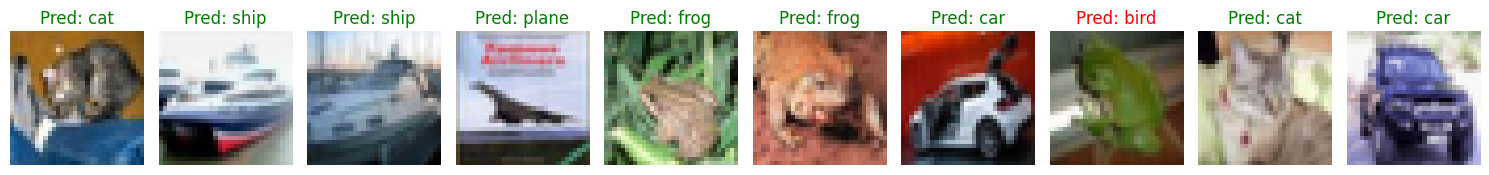

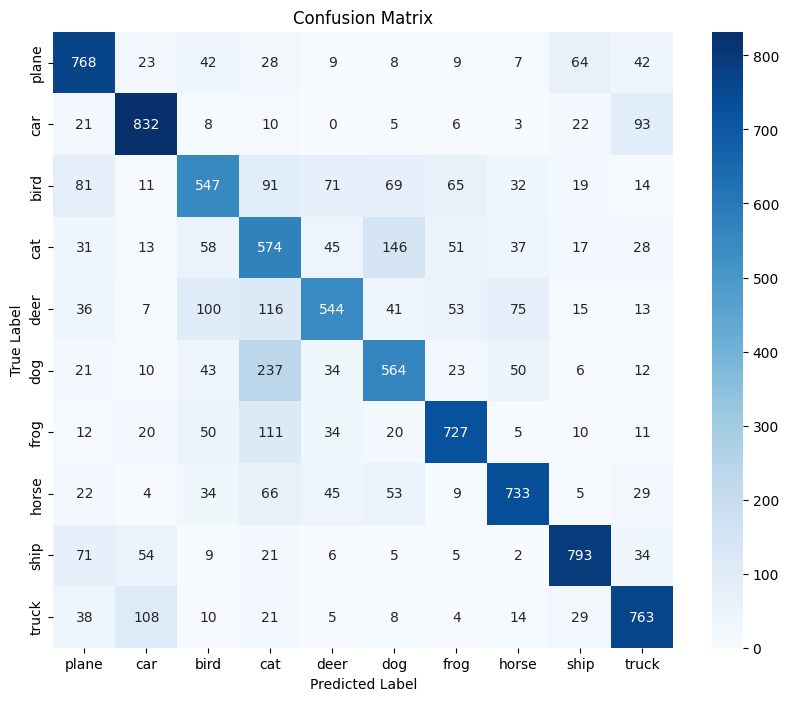

Training:  57%|█████▋    | 57/100 [02:50<02:08,  3.00s/it, train_loss=0.3136, train_f1=0.8918, val_f1=0.6870]

Early stopping
Traceback (most recent call last):
  File "/tmp/ipykernel_63827/138798577.py", line 254, in train
    epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
  File "/tmp/ipykernel_63827/138798577.py", line 207, in track_progress
    raise optuna.TrialPruned()
optuna.exceptions.TrialPruned



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇███
train_acc,▁▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
train_f1,▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
train_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_precision,▁▂▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████
train_recall,▁▃▃▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇██████
val_acc,▁▃▄▄▅▅▅▆▆▆▇▇▇▇▇▇▇█▇▇████████████████████
val_f1,▁▃▃▄▄▅▆▆▆▆▇▇▇▇▇▇▇███████████████████████
val_precision,▁▂▃▃▄▅▅▆▆▆▇▇▇▇█▇▇██████▇████████████████
val_recall,▁▂▃▃▄▅▅▅▆▆▆▆▆▇▇▇▇██████████████▇████████
epoch,56


Student(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

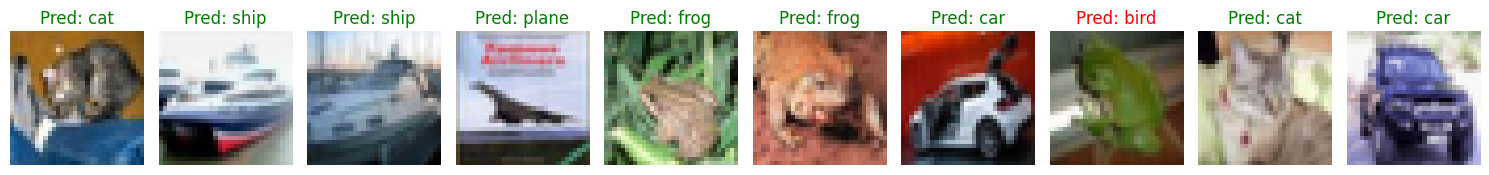

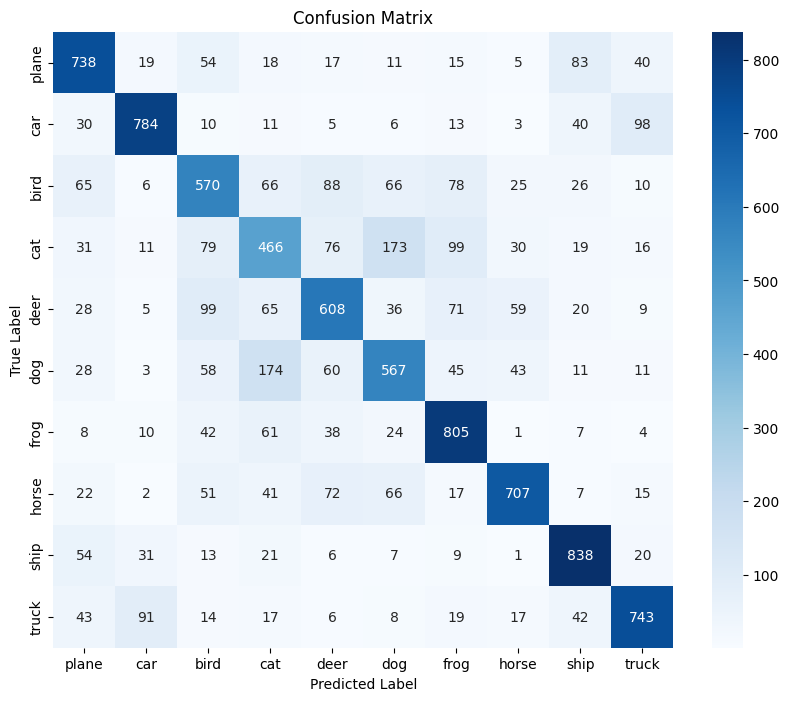

In [32]:
trainer.train(Student(), loss_fn, optim.Adam, {'lr': 0.0017578769390202366})

In [12]:
trainer = ModelTrainer(train_loader, test_loader, classes)
loss_fn = torch.nn.CrossEntropyLoss()

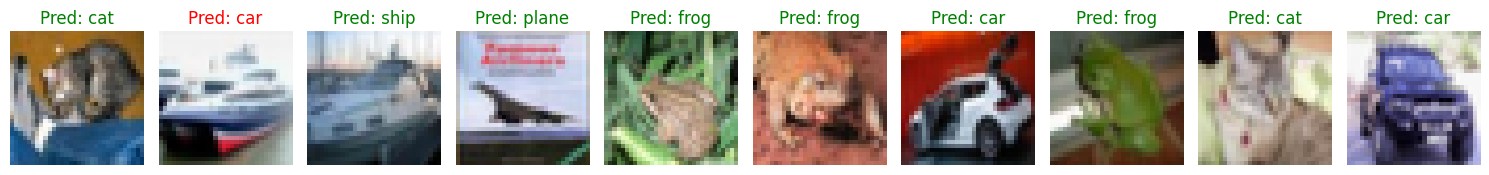

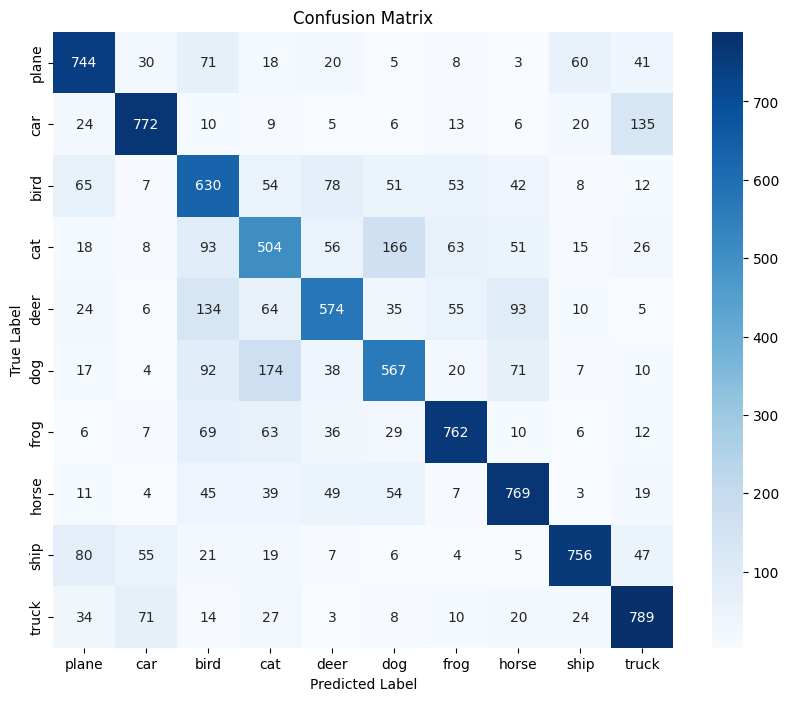

Training:  42%|████▏     | 42/100 [02:17<03:09,  3.27s/it, train_loss=0.4270, train_f1=0.8540, val_f1=0.6880]

Early stopping
Traceback (most recent call last):
  File "/tmp/ipykernel_15682/2525111931.py", line 135, in train
    epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
  File "/tmp/ipykernel_15682/3489537561.py", line 92, in track_progress
    raise optuna.TrialPruned()
optuna.exceptions.TrialPruned



epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
train_acc,▁▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_f1,▁▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_loss,█▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_precision,▁▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_recall,▁▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
val_acc,▁▂▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████████████████
val_f1,▁▃▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_precision,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇████████████████████
val_recall,▁▂▃▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇████████████████████
epoch,41


Student(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

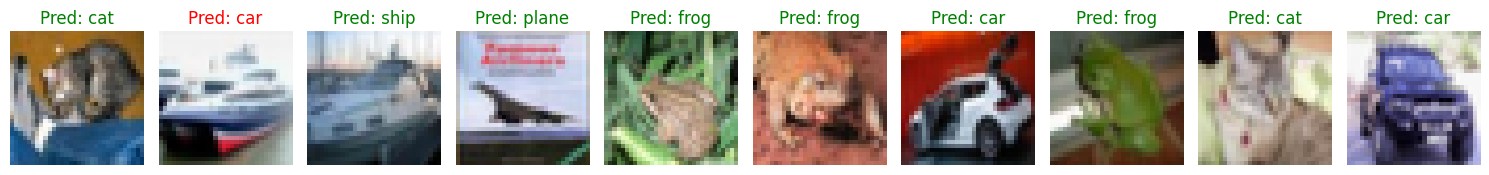

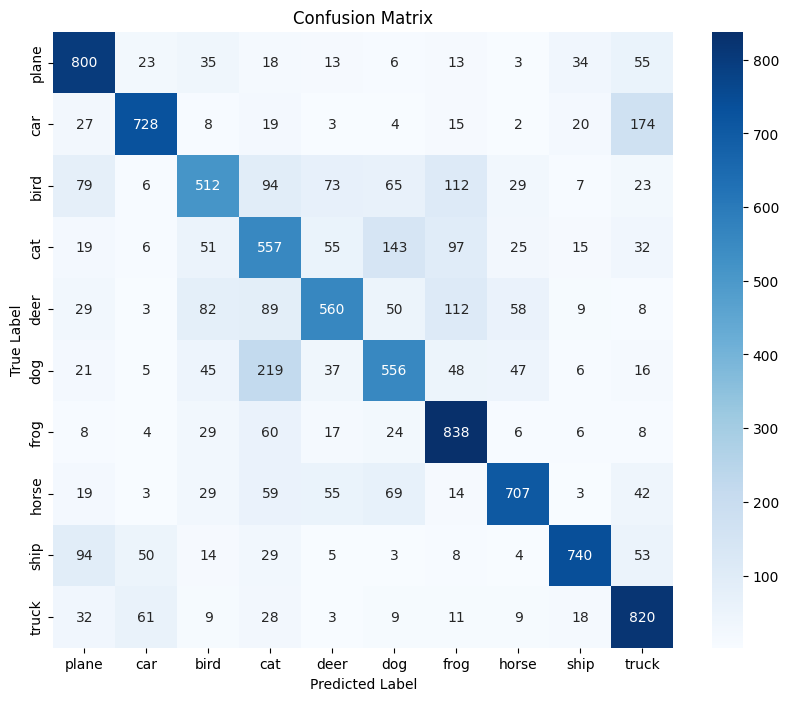

In [13]:
trainer.train(Student(), loss_fn, optim.Adam, {'lr': 0.0017578769390202366})

# Эксперимент 1 - Дистилляция логитов

In [17]:
teacher_model = Teacher()
teacher_model.load_state_dict(torch.load('weights/teacher.pth')['model_state_dict'])
teacher_model.eval()

/tmp/ipykernel_15682/4118748281.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_model.load_state_dict(torch.load('weights/teacher.pth')['model_state_dict'])


Teacher(
  (features): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=512, out_features=10, bias=True)
  )
)

In [ ]:
class ModelTrainerDistil(ModelTrainer):
    def train_epoch(self, model, teacher_model, optimizer, loss_fn, 
                    temperature, loss_weight, soft_target_loss_weight, device):
        model.train()
        losses = []
        all_preds = []
        all_labels = []
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                teacher_logits = teacher_model(inputs)
            model_logits = model(inputs)
            # Cross-entropy loss
            soft_targets = nn.functional.softmax(teacher_logits / temperature, dim=-1)
            soft_prob = nn.functional.log_softmax(model_logits / temperature, dim=-1)

            # Calculate the soft targets loss. Scaled by T**2 as suggested by the authors of the paper "Distilling the knowledge in a neural network"
            soft_targets_loss = torch.sum(soft_targets * (soft_targets.log() - soft_prob)) \
                / soft_prob.size()[0] * (temperature**2)

            model_loss = loss_fn(model_logits, labels)
            losses.append(model_loss.item())
            # Calculate the true label loss
            loss = loss_weight * model_loss +  soft_target_loss_weight * soft_targets_loss

            # Weighted sum of the two losses
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(model_logits, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        all_preds = np.hstack(all_preds)
        all_labels = np.hstack(all_labels)


        metrics = {
            'train_loss': np.mean(losses),
            'train_acc': np.mean(np.array(all_preds) == np.array(all_labels)),
            'train_precision': precision_score(all_labels, all_preds, average='weighted'),
            'train_recall': recall_score(all_labels, all_preds, average='weighted')
        }
        metrics['train_f1'] = 2 * metrics['train_precision'] * metrics['train_recall'] \
              / (metrics['train_precision'] + metrics['train_recall'])
        
        return model, metrics


    def train(self, model, teacher_model, loss_fn, optim_class, optim_args, 
              cleanup_before=True, temperature=2, loss_weight=0.75, soft_target_loss_weight=0.25,
              device='cuda' if torch.cuda.is_available() else 'cpu', 
              n_epochs=100, patience=10, trial=None, save_model=True):
        run = wandb.init(project=self.project_name, name=f'{model.__class__.__name__}_{optim_class.__name__}lr{np.round(optim_args["lr"], 5)}_logit_distil')
        optimizer = optim_class(model.parameters(), **optim_args)
        model = model.to(device)
        teacher_model = teacher_model.to(device)
        teacher_model.eval()
        self.best_model_path = None
        progress_bar = tqdm(range(n_epochs), desc='Training', leave=True)
        epochs_without_improvement = 0
        if cleanup_before:
            self.cleanup()
        try:
            for epoch in progress_bar:
                # Training phase
                model, train_metrics = self.train_epoch(model, teacher_model, optimizer, loss_fn,
                                                        temperature, loss_weight, soft_target_loss_weight,  device)
                
                # Validation phase
                val_metrics, cm_plot, pred_plot = self.validate(model, device)
                metrics = {**train_metrics, **val_metrics, 'epoch': epoch}
                epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
                if epochs_without_improvement == 0:
                    self.save_model_locally(model, optimizer, metrics)
                self.log_metrics(run, metrics, cm_plot, epoch, progress_bar, n_epochs)
                clear_output(wait=True)
                plt.show()
        except (Exception, KeyboardInterrupt) as e:
            print(traceback.format_exc())
        finally:
            if save_model and self.best_model_path:
                self.save_model_to_wandb(run)
            progress_bar.close()
            wandb.finish()
        return model
        

In [ ]:
trainer = ModelTrainerDistil(train_loader, test_loader, classes)
loss_fn = torch.nn.CrossEntropyLoss()

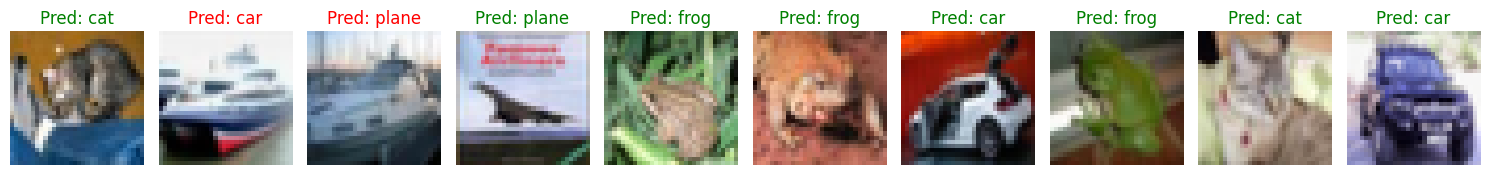

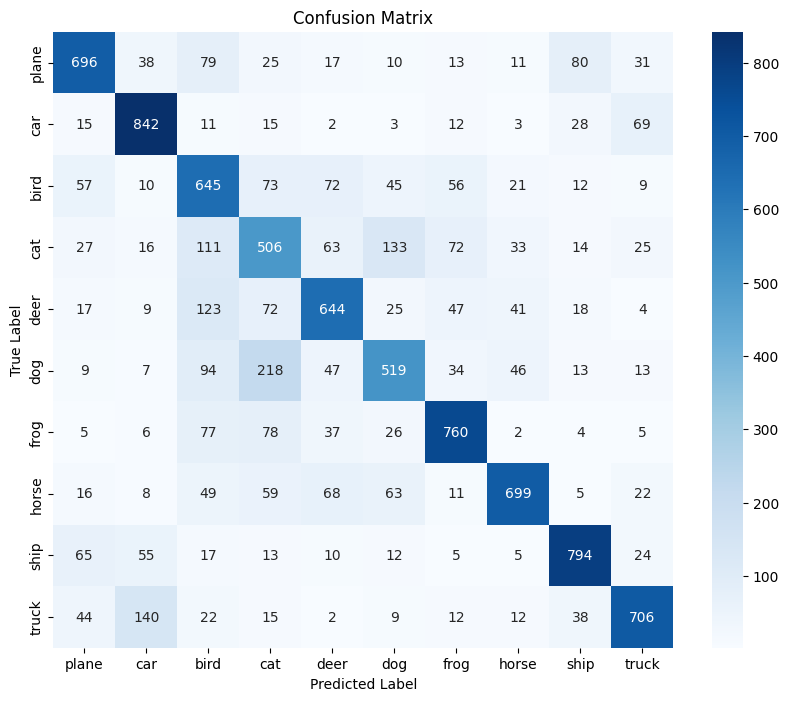

Training: 100%|██████████| 100/100 [08:03<00:00,  4.83s/it, train_loss=0.1619, train_f1=0.9431, val_f1=0.6839]


epoch,▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▃▃▃▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████
train_f1,▁▂▂▃▃▃▄▄▄▄▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇████████
train_loss,█▆▆▆▆▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_precision,▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇████████████
train_recall,▁▁▂▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇████████████
val_acc,▁▂▂▃▃▅▅▆▆▆▇▇▇▇▇████████████████████████▇
val_f1,▁▃▄▅▅▇▇▇▇▇▇▇▇███████████████████████████
val_precision,▁▂▃▄▄▆▆▇▇▇██████████████████████████████
val_recall,▁▃▆▆▆▇▇▇▇▇██████████████████████████████
epoch,99


Student(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [34]:

trainer.train(Student(), teacher_model, loss_fn, optim.Adam, {'lr': 0.0017578769390202366}, patience=100)

# Эксперимент 2 - Учим Студента совпадать по скрытому состоянию с Учителем (без модификации и обучения архитектур)

In [37]:
class TeacherCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        flattened_conv_output_after_pooling = torch.nn.functional.avg_pool1d(flattened_conv_output, 2)
        return x, flattened_conv_output_after_pooling

# Create a similar student class where we return a tuple. We do not apply pooling after flattening.
class StudentCosine(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentCosine, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        flattened_conv_output = torch.flatten(x, 1)
        x = self.classifier(flattened_conv_output)
        return x, flattened_conv_output

In [39]:
# We do not have to train the modified deep network from scratch of course, we just load its weights from the trained instance
teacher_cosine = TeacherCosine(num_classes=10)
teacher_cosine.load_state_dict(torch.load('weights/teacher.pth')['model_state_dict'])

/tmp/ipykernel_15682/4033368019.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_cosine.load_state_dict(torch.load('weights/teacher.pth')['model_state_dict'])


<All keys matched successfully>

In [41]:
# Once again ensure the norm of the first layer is the same for both networks
print("Norm of 1st layer for deep_nn:", torch.norm(teacher_model.features[0].weight).item())
print("Norm of 1st layer for modified_deep_nn:", torch.norm(teacher_cosine.features[0].weight).item())

Norm of 1st layer for deep_nn: 7.897770404815674
Norm of 1st layer for modified_deep_nn: 7.897770404815674


In [43]:
# Initialize a modified lightweight network with the same seed as our other lightweight instances. This will be trained from scratch to examine the effectiveness of cosine loss minimization.
student_cosine = StudentCosine(num_classes=10)
print("Norm of 1st layer:", torch.norm(student_cosine.features[0].weight).item())

Norm of 1st layer: 2.3168935775756836


In [44]:
# Create a sample input tensor
sample_input = torch.randn(128, 3, 32, 32) # Batch size: 128, Filters: 3, Image size: 32x32

# Pass the input through the student
logits, hidden_representation = student_cosine(sample_input)

# Print the shapes of the tensors
print("Student logits shape:", logits.shape) # batch_size x total_classes
print("Student hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

# Pass the input through the teacher
logits, hidden_representation = teacher_cosine(sample_input)

# Print the shapes of the tensors
print("Teacher logits shape:", logits.shape) # batch_size x total_classes
print("Teacher hidden representation shape:", hidden_representation.shape) # batch_size x hidden_representation_size

Student logits shape: torch.Size([128, 10])
Student hidden representation shape: torch.Size([128, 1024])
Teacher logits shape: torch.Size([128, 10])
Teacher hidden representation shape: torch.Size([128, 1024])


In [61]:
class ModelTrainerCosineDistil(ModelTrainer):
    def train_epoch(self, model, teacher_model, optimizer, loss_fn, 
                    loss_weight, hidden_rep_loss_weight, device):
        model.train()
        losses = []
        all_preds = []
        all_labels = []
        cosine_loss = nn.CosineEmbeddingLoss()
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                 _, teacher_hidden_representation = teacher_model(inputs)
            model_logits, student_hidden_representation = model(inputs)
            # Cross-entropy loss
            hidden_rep_loss = cosine_loss(student_hidden_representation, teacher_hidden_representation, target=torch.ones(inputs.size(0)).to(device))

            # Calculate the true label loss
            model_loss = loss_fn(model_logits, labels)
            losses.append(model_loss.item())

            # Weighted sum of the two losses
            loss = hidden_rep_loss_weight * hidden_rep_loss + loss_weight * model_loss

            # Calculate the true label loss
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(model_logits, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        all_preds = np.hstack(all_preds)
        all_labels = np.hstack(all_labels)


        metrics = {
            'train_loss': np.mean(losses),
            'train_acc': np.mean(np.array(all_preds) == np.array(all_labels)),
            'train_precision': precision_score(all_labels, all_preds, average='weighted'),
            'train_recall': recall_score(all_labels, all_preds, average='weighted')
        }
        metrics['train_f1'] = 2 * metrics['train_precision'] * metrics['train_recall'] \
              / (metrics['train_precision'] + metrics['train_recall'])
        
        return model, metrics
    
    def validate(self, model, device):
        model.eval()
        all_preds = []
        
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs, _ = model(inputs)
                _, preds = torch.max(outputs, 1)
                
                all_preds.append(preds.cpu().numpy())
        all_preds = np.hstack(all_preds)

        metrics = {
            'val_acc': np.mean(all_preds == self.true_val_labels),
            'val_precision': precision_score(self.true_val_labels, all_preds, average='weighted'),
            'val_recall': recall_score(self.true_val_labels, all_preds, average='weighted')
        }
        metrics['val_f1'] = 2 * metrics['val_precision'] * metrics['val_recall'] \
              / (metrics['val_precision'] + metrics['val_recall'])
        
        # Create and log confusion matrix
        pred_plot = self.visualize_samples(self.samples, all_preds[:self.preview_samples_n], 
                                           self.true_val_labels[:self.preview_samples_n])
        cm_plot = self.create_confusion_matrix_plot(self.true_val_labels, all_preds)
        
        return metrics, cm_plot, pred_plot


    def train(self, model, teacher_model, loss_fn, optim_class, optim_args, 
              cleanup_before=True, loss_weight=0.75, hidden_rep_loss_weight=0.25,
              device='cuda' if torch.cuda.is_available() else 'cpu', 
              n_epochs=100, patience=10, trial=None, save_model=True):
        run = wandb.init(project=self.project_name, name=f'{model.__class__.__name__}_{optim_class.__name__}lr{np.round(optim_args["lr"], 5)}_hidden_cosine_distil')
        optimizer = optim_class(model.parameters(), **optim_args)
        model = model.to(device)
        teacher_model = teacher_model.to(device)
        teacher_model.eval()
        self.best_model_path = None
        progress_bar = tqdm(range(n_epochs), desc='Training', leave=True)
        epochs_without_improvement = 0
        if cleanup_before:
            self.cleanup()
        try:
            for epoch in progress_bar:
                # Training phase
                model, train_metrics = self.train_epoch(model, teacher_model, optimizer, loss_fn,
                                                        loss_weight, hidden_rep_loss_weight,  device)
                
                # Validation phase
                val_metrics, cm_plot, pred_plot = self.validate(model, device)
                metrics = {**train_metrics, **val_metrics, 'epoch': epoch}
                epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
                if epochs_without_improvement == 0:
                    self.save_model_locally(model, optimizer, metrics)
                self.log_metrics(run, metrics, cm_plot, epoch, progress_bar, n_epochs)
                clear_output(wait=True)
                plt.show()
        except (Exception, KeyboardInterrupt) as e:
            print(traceback.format_exc())
        finally:
            if save_model and self.best_model_path:
                self.save_model_to_wandb(run)
            progress_bar.close()
            wandb.finish()
        return model
        

In [62]:
trainer = ModelTrainerCosineDistil(train_loader, test_loader, classes)
loss_fn = torch.nn.CrossEntropyLoss()

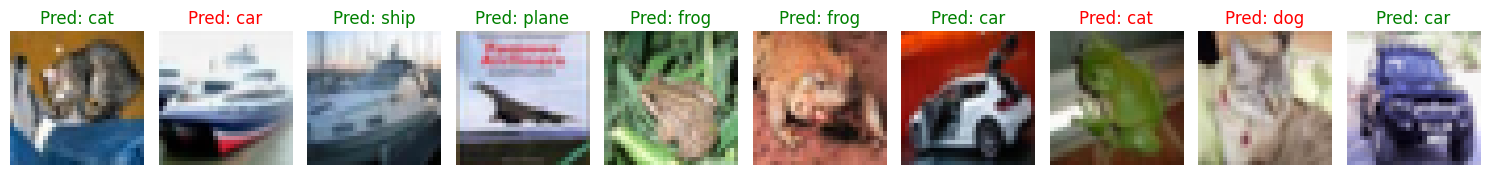

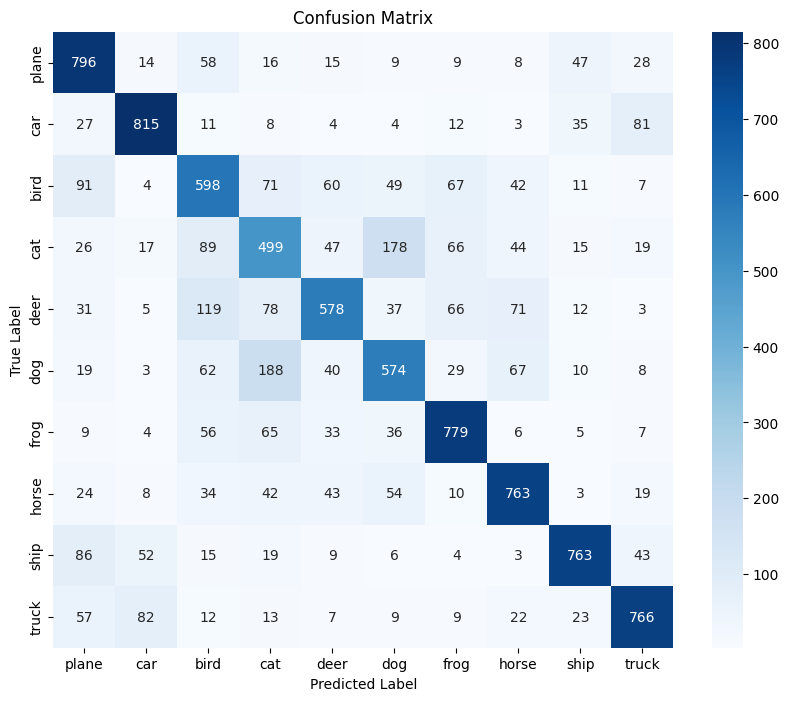

Training: 100%|██████████| 100/100 [08:01<00:00,  4.81s/it, train_loss=0.1472, train_f1=0.9498, val_f1=0.6937]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇████
train_acc,▁▂▃▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████████████
train_f1,▁▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████████
train_loss,█▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁
train_precision,▁▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████████
train_recall,▁▂▃▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇███████████
val_acc,▁▃▅▆▆▇▇▇▇▇██████████████████████████████
val_f1,▁▃▄▅▅▆▆▇▇▇▇█████████████████████████████
val_precision,▁▂▄▄▆▇▇▇▇▇▇▇▇▇██████████████████████████
val_recall,▁▃▄▅▅▆▆▆▇▇▇▇████████████████████████████
epoch,99


StudentCosine(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [63]:
trainer.train(StudentCosine(), teacher_cosine, loss_fn, optim.Adam, {'lr': 0.0017578769390202366}, patience=100)

# Эксперимент 3 - Добавляем обучаемый регрессор

In [65]:
class TeacherRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(TeacherRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        conv_feature_map = x
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, conv_feature_map

class StudentRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super(StudentRegressor, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Include an extra regressor (in our case linear)
        self.regressor = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        regressor_output = self.regressor(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x, regressor_output

In [ ]:
class RegressorTrainerMSEDistil(ModelTrainerCosineDistil):
    def train_epoch(self, model, teacher_model, optimizer, loss_fn, 
                    loss_weight, feature_map_weight, device):
        model.train()
        losses = []
        all_preds = []
        all_labels = []
        mse_loss = nn.MSELoss()
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                 _, teacher_feature_map = teacher_model(inputs)
            model_logits, regressor_feature_map = model(inputs)
            # Cross-entropy loss
            model_loss = loss_fn(model_logits, labels)
            losses.append(model_loss.item())

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            # Weighted sum of the two losses
            loss = feature_map_weight * hidden_rep_loss + loss_weight * model_loss


            # Calculate the true label loss
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(model_logits, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        all_preds = np.hstack(all_preds)
        all_labels = np.hstack(all_labels)


        metrics = {
            'train_loss': np.mean(losses),
            'train_acc': np.mean(np.array(all_preds) == np.array(all_labels)),
            'train_precision': precision_score(all_labels, all_preds, average='weighted'),
            'train_recall': recall_score(all_labels, all_preds, average='weighted')
        }
        metrics['train_f1'] = 2 * metrics['train_precision'] * metrics['train_recall'] \
              / (metrics['train_precision'] + metrics['train_recall'])
        
        return model, metrics
    
    def train(self, model, teacher_model, loss_fn, optim_class, optim_args, 
              cleanup_before=True, loss_weight=0.75, feature_map_weight=0.25,
              device='cuda' if torch.cuda.is_available() else 'cpu', 
              n_epochs=100, patience=10, trial=None, save_model=True):
        run = wandb.init(project=self.project_name, name=f'{model.__class__.__name__}_{optim_class.__name__}lr{np.round(optim_args["lr"], 5)}_regressor_distil')
        optimizer = optim_class(model.parameters(), **optim_args)
        model = model.to(device)
        teacher_model = teacher_model.to(device)
        teacher_model.eval()
        self.best_model_path = None
        progress_bar = tqdm(range(n_epochs), desc='Training', leave=True)
        epochs_without_improvement = 0
        if cleanup_before:
            self.cleanup()
        try:
            for epoch in progress_bar:
                # Training phase
                model, train_metrics = self.train_epoch(model, teacher_model, optimizer, loss_fn,
                                                        loss_weight, feature_map_weight,  device)
                
                # Validation phase
                val_metrics, cm_plot, pred_plot = self.validate(model, device)
                metrics = {**train_metrics, **val_metrics, 'epoch': epoch}
                epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
                if epochs_without_improvement == 0:
                    self.save_model_locally(model, optimizer, metrics)
                self.log_metrics(run, metrics, cm_plot, epoch, progress_bar, n_epochs)
                clear_output(wait=True)
                plt.show()
        except (Exception, KeyboardInterrupt) as e:
            print(traceback.format_exc())
        finally:
            if save_model and self.best_model_path:
                self.save_model_to_wandb(run)
            progress_bar.close()
            wandb.finish()
        return model
        

In [78]:
trainer = RegressorTrainerMSEDistil(train_loader, test_loader, classes)
loss_fn = torch.nn.CrossEntropyLoss()

In [79]:
teacher_regressor = TeacherRegressor(num_classes=10)
teacher_regressor.load_state_dict(torch.load('weights/teacher.pth')['model_state_dict'])

/tmp/ipykernel_15682/2599840228.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  teacher_regressor.load_state_dict(torch.load('weights/teacher.pth')['model_state_dict'])


<All keys matched successfully>

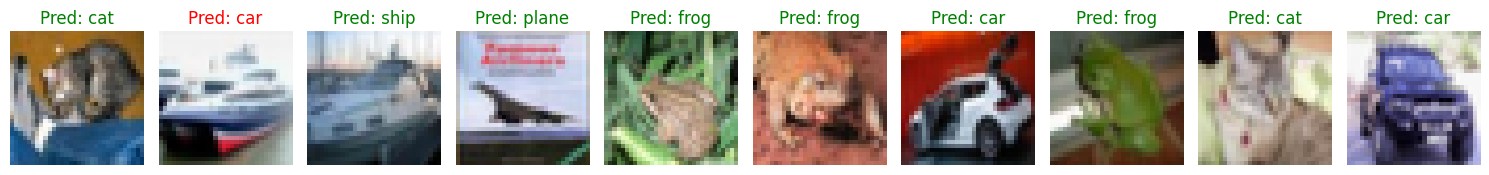

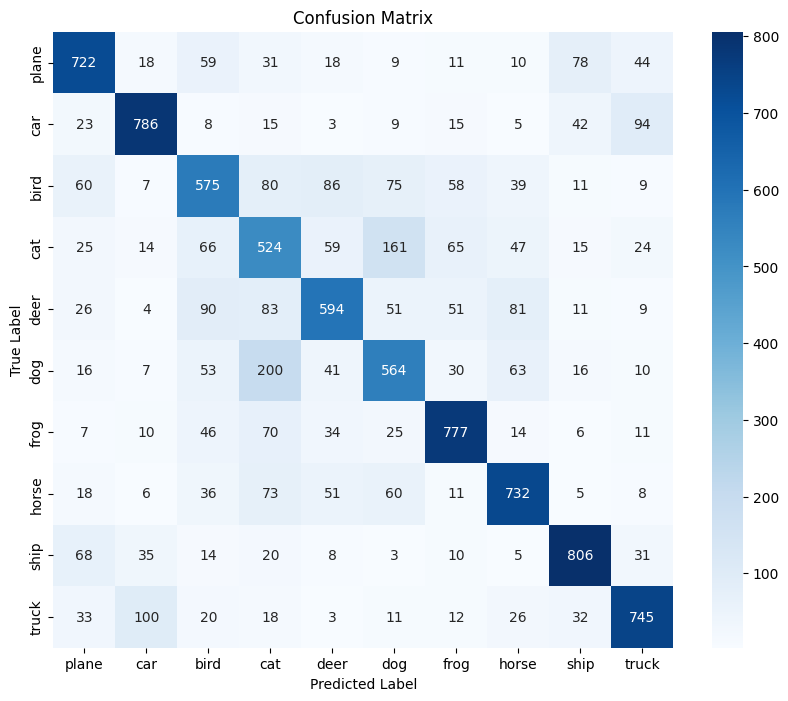

Training: 100%|██████████| 100/100 [08:01<00:00,  4.81s/it, train_loss=0.0909, train_f1=0.9699, val_f1=0.6831]


epoch,▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_acc,▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇███████████████
train_f1,▁▁▂▃▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███████████████
train_loss,█▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▃▃▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████
train_recall,▁▂▂▂▃▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇███████████████████
val_acc,▁▂▃▅▅▆▆▇▆▇▇█▇███████████████████████████
val_f1,▁▃▄▅▆▇▇▇▇▇██████████████████████████████
val_precision,▁▄▄▄▄▆▇▆▇▇███████████▇▇██▇██▇█▇█▇█▇█▇▇█▇
val_recall,▁▆▆▆▆▇▇▇████████████████████████████████
epoch,99


StudentRegressor(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [80]:
trainer.train(StudentRegressor(), teacher_regressor, loss_fn, optim.Adam, {'lr': 0.0017578769390202366}, patience=100)

# Комбинация экспетимента 1 и 3

In [81]:
class RegressorTrainerMSEPlusLogitDistil(RegressorTrainerMSEDistil):
    def train_epoch(self, model, teacher_model, optimizer, loss_fn, 
                    loss_weight, feature_map_weight, device):
        model.train()
        losses = []
        all_preds = []
        all_labels = []
        mse_loss = nn.MSELoss()
        
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                 teacher_logits, teacher_feature_map = teacher_model(inputs)
            model_logits, regressor_feature_map = model(inputs)
            # Cross-entropy loss
            model_loss = loss_fn(model_logits, labels)
            losses.append(model_loss.item())

            # Calculate the loss
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)

            teacher_loss = loss_fn(teacher_logits, labels)

            # Weighted sum of the two losses
            loss = (feature_map_weight * hidden_rep_loss + loss_weight * model_loss + feature_map_weight * teacher_loss.item() + loss_weight * model_loss) / 2


            # Calculate the true label loss
            loss.backward()
            optimizer.step()
            
            _, preds = torch.max(model_logits, 1)
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
        all_preds = np.hstack(all_preds)
        all_labels = np.hstack(all_labels)


        metrics = {
            'train_loss': np.mean(losses),
            'train_acc': np.mean(np.array(all_preds) == np.array(all_labels)),
            'train_precision': precision_score(all_labels, all_preds, average='weighted'),
            'train_recall': recall_score(all_labels, all_preds, average='weighted')
        }
        metrics['train_f1'] = 2 * metrics['train_precision'] * metrics['train_recall'] \
              / (metrics['train_precision'] + metrics['train_recall'])
        
        return model, metrics
    
    def train(self, model, teacher_model, loss_fn, optim_class, optim_args, 
              cleanup_before=True, loss_weight=0.75, feature_map_weight=0.25,
              device='cuda' if torch.cuda.is_available() else 'cpu', 
              n_epochs=100, patience=10, trial=None, save_model=True):
        run = wandb.init(project=self.project_name, name=f'{model.__class__.__name__}_{optim_class.__name__}lr{np.round(optim_args["lr"], 5)}_regressor_logit_distil')
        optimizer = optim_class(model.parameters(), **optim_args)
        model = model.to(device)
        teacher_model = teacher_model.to(device)
        teacher_model.eval()
        self.best_model_path = None
        progress_bar = tqdm(range(n_epochs), desc='Training', leave=True)
        epochs_without_improvement = 0
        if cleanup_before:
            self.cleanup()
        try:
            for epoch in progress_bar:
                # Training phase
                model, train_metrics = self.train_epoch(model, teacher_model, optimizer, loss_fn,
                                                        loss_weight, feature_map_weight,  device)
                
                # Validation phase
                val_metrics, cm_plot, pred_plot = self.validate(model, device)
                metrics = {**train_metrics, **val_metrics, 'epoch': epoch}
                epochs_without_improvement = self.track_progress(metrics, patience, trial, epoch, epochs_without_improvement)
                if epochs_without_improvement == 0:
                    self.save_model_locally(model, optimizer, metrics)
                self.log_metrics(run, metrics, cm_plot, epoch, progress_bar, n_epochs)
                clear_output(wait=True)
                plt.show()
        except (Exception, KeyboardInterrupt) as e:
            print(traceback.format_exc())
        finally:
            if save_model and self.best_model_path:
                self.save_model_to_wandb(run)
            progress_bar.close()
            wandb.finish()
        return model
        

In [83]:
trainer = RegressorTrainerMSEPlusLogitDistil(train_loader, test_loader, classes)
loss_fn = torch.nn.CrossEntropyLoss()

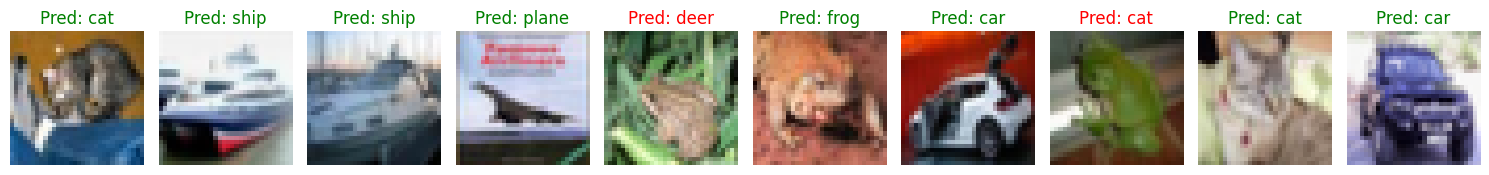

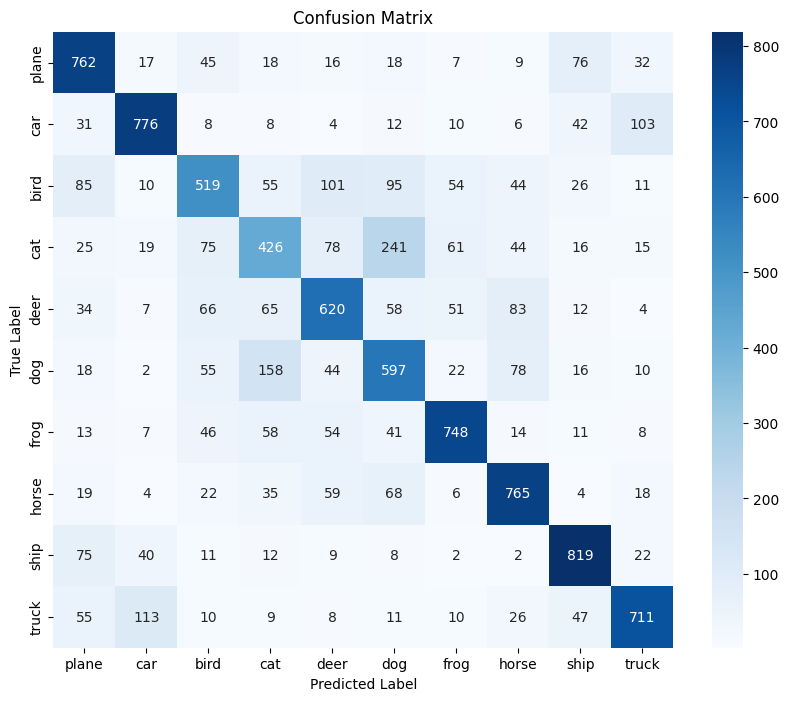

Training: 100%|██████████| 100/100 [07:44<00:00,  4.64s/it, train_loss=0.0773, train_f1=0.9750, val_f1=0.6736]


epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇█████
train_acc,▁▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████
train_f1,▁▃▄▄▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇███████████████████
train_loss,█▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_precision,▁▂▃▃▃▄▄▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇████████████████
train_recall,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇▇███████████████████
val_acc,▁▂▃▃▄▆▆▆▇█████████████████▇███▇█▇███▇▇▇▇
val_f1,▁▅▅▆▆▇▇▇▇▇███████████████████████████▇█▇
val_precision,▁▄▅▅▆▇▇██████████████████▇█▇█▇▇█▇▇▇▇▇▇▇▇
val_recall,▁▃▄▅▅▇▇▇███████████████████████████████▇
epoch,99


StudentRegressor(
  (features): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regressor): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)

In [84]:
trainer.train(StudentRegressor(), teacher_regressor, loss_fn, optim.Adam, {'lr': 0.0017578769390202366}, patience=100)
